# ROI classification analysis

As an observation from [a09_extended_exploratory.ipynb](https://github.com/Upward-Spiral-Science/claritycontrol/blob/master/assignments/a09_extended_exploratory.ipynb), the experiment conditions could be classified by comparing the same brain region of different subjects. Each region called an ROI with a specific annotation number.

# Setup

Setup environment and read data

In [1]:
FEATURES_PATH = '../code/data/roi_features/features.csv'  # use your own path

import numpy as np
import matplotlib
matplotlib.use('AGG')  # avoid some error in matplotlib, delete this line if the following doesn't work
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import jgraph as ig
%matplotlib inline

# DATA description (column description)
# 0. class label [0=cocaine | 1=control | 2=fear]
# 1. brain number
# 2. roi number
# 3. roi position X
# 4. roi position Y
# 5. roi position Z
# 6. roi mean
# 7. roi std
# 8. Haralick feature - Energy
# 9. Haralick feature - Entropy
# 10. Haralick feature - Correlation
# 11. Haralick feature - Contrast
# 12. Haralick feature - Variance
# 13. Haralick feature - SumMean
# 14. Haralick feature - Inertia
# 15. Haralick feature - Cluster Shade
# 16. Haralick feature - Cluster tendency
# 17. Haralick feature - Homogeneity
# 18. Haralick feature - MaxProbability
# 19. Haralick feature - Inverse Variance
fields = ['label','nbrain','nroi','roix','roiy','roiy','mean','std','energy','entropy','correlation','contrast','variance',
          'summean','inertia','cluster shade','cluster tendency','homogeneity','maxProbability','inverse variance']
data = np.genfromtxt(FEATURES_PATH, delimiter=",", dtype=np.float32)# the features data have been pre-processed and merged

brain_nums = np.unique(data[:,1])
roi_nums = np.unique(data[:,2])

# preview - print brain numbers
print brain_nums

# preview - print roi numbers
print roi_nums

print data.shape

/Users/david/.envs/clarityenv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


[ 173.  174.  175.  177.  178.  181.  182.  187.  188.  189.  197.  199.
  200.  239.  258.]
[  50.   55.   56.   67.   79.   87.  110.  131.  250.  258.  266.  303.
  311.  439.  447.  451.  455.  464.  471.  544.  551.  559.  587.  652.
  660.  749.  872.]
(405, 20)


## Independent test

Test covariance matrix on the data of a certain region

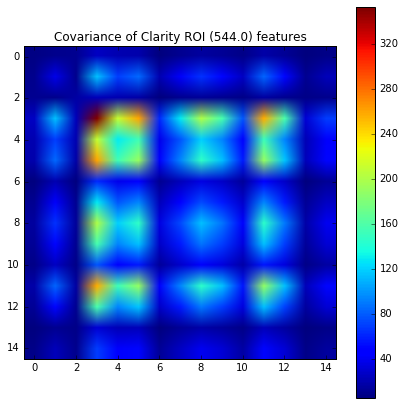

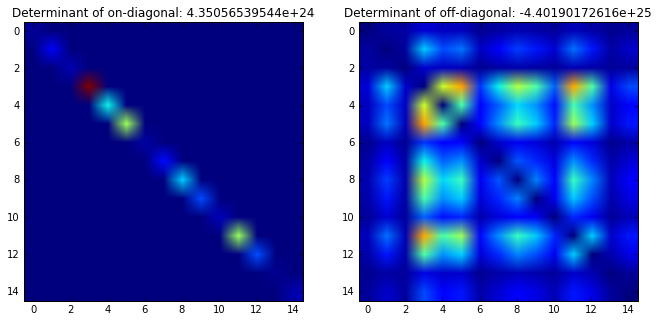

Ratio of on- and off-diagonal determinants: -0.0988337692683


In [2]:
ROI_NUM = roi_nums[19]  # which region would like to study?

vectorized = data[data[:,2]==ROI_NUM, 6:19]
covar = np.cov(vectorized)

plt.figure(figsize=(7,7))
plt.imshow(covar)
plt.title('Covariance of Clarity ROI (%s) features'%(ROI_NUM))
plt.colorbar()
plt.show()

diag = covar.diagonal()*np.eye(covar.shape[0])
hollow = covar-diag
d_det = np.linalg.det(diag)
h_det = np.linalg.det(hollow)

plt.figure(figsize=(11,8))
plt.subplot(121)
plt.imshow(diag)
plt.clim([0, np.max(covar)])
plt.title('Determinant of on-diagonal: ' + str(d_det))
plt.subplot(122)
plt.imshow(hollow)
plt.clim([0, np.max(covar)])
plt.title('Determinant of off-diagonal: ' + str(h_det))
plt.show()

print "Ratio of on- and off-diagonal determinants: " + str(d_det/h_det)

## Clustering test

Ideally, the best number of clusters should be 3.

[ 1  2  3  4  5  6  7  8  9 10 11 12]
Fitting and evaluating model with 1 clusters.
Fitting and evaluating model with 2 clusters.
Fitting and evaluating model with 3 clusters.
Fitting and evaluating model with 4 clusters.
Fitting and evaluating model with 5 clusters.
Fitting and evaluating model with 6 clusters.
Fitting and evaluating model with 7 clusters.
Fitting and evaluating model with 8 clusters.
Fitting and evaluating model with 9 clusters.
Fitting and evaluating model with 10 clusters.
Fitting and evaluating model with 11 clusters.
Fitting and evaluating model with 12 clusters.


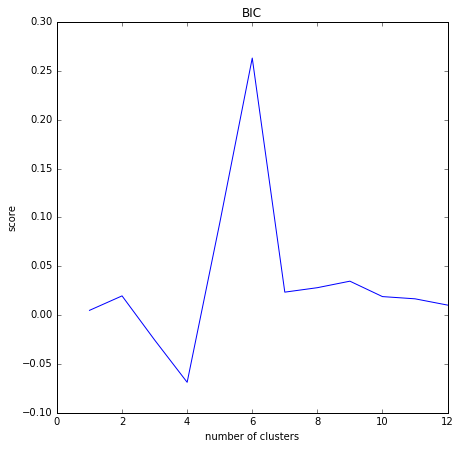

[ 203.43204235   50.69708361  -39.36862019  -14.54506186   10.6206499
    3.79849271   42.44201602   35.55998653   28.74767509   52.61676363
   59.74912811   97.07038503]


In [3]:
import sklearn.mixture
i = np.linspace(1,12,12,dtype='int')
print i
bic = np.array(())
for idx in i:
    print "Fitting and evaluating model with " + str(idx) + " clusters."
    gmm = sklearn.mixture.GMM(n_components=idx,n_iter=1000,covariance_type='diag')
    gmm.fit(vectorized)
    bic = np.append(bic, gmm.bic(vectorized))
plt.figure(figsize=(7,7))
plt.plot(i, 1.0/bic)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.show()
print bic

## Classification Test

In [4]:
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline

names = ["Nearest Neighbors", "Linear SVM", "Random Forest",
         "Linear Discriminant Analysis", "Quadratic Discriminant Analysis"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

In [7]:
accuracy = np.zeros((len(classifiers), 2), dtype=np.dtype('float64'))
X=data[data[:,2]==ROI_NUM, 8:19]
y=data[data[:,2]==ROI_NUM, 0]
for idx, cla in enumerate(classifiers):
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=0)
        clf = cla.fit(X_train, y_train)
        loo = LeaveOneOut(len(X))
        scores = cross_validation.cross_val_score(clf, X, y, cv=loo)
        accuracy[idx,] = [scores.mean(), scores.std()]
        print("Accuracy of %s: %0.2f (+/- %0.2f)" % (names[idx], scores.mean(), scores.std() * 2))
        
print accuracy

Accuracy of Nearest Neighbors: 0.13 (+/- 0.68)
Accuracy of Linear SVM: 0.53 (+/- 1.00)
Accuracy of Random Forest: 0.47 (+/- 1.00)
Accuracy of Linear Discriminant Analysis: 0.27 (+/- 0.88)
Accuracy of Quadratic Discriminant Analysis: 0.07 (+/- 0.50)
[[ 0.13333333  0.33993463]
 [ 0.53333333  0.49888765]
 [ 0.46666667  0.49888765]
 [ 0.26666667  0.44221664]
 [ 0.06666667  0.24944383]]


/Users/david/.envs/clarityenv/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
